In [ ]:
# add noise to the original dataset

In [32]:
import pandas as pd
import numpy as np

# load the original dataset
dataset = pd.read_csv('../dataset/amidation.csv')

# calculate the mean and standard deviation for noise generation
mu = 0
sigma = 0.1 * dataset['yield'].mean()

# create Gaussian noise with the same dimension as the 'yield' column
noise = np.random.normal(mu, sigma, dataset['yield'].shape)

# add the noise to the 'yield' column
dataset['yield'] = dataset['yield'] + noise

# save the modified dataset to a new CSV file
dataset.to_csv('../dataset/noisy_amidation.csv', index=False)

In [ ]:
# Compare five representative algorithms

In [34]:
%%time
%%capture
import pandas as pd
from algos_regret import EpsilonGreedy, UCB1, UCB1Tuned,ThompsonSamplingGaussianFixedVarSquared, BayesUCBGaussian
from chem_arms import simulate_propose_and_update
import utils
from utils import make_dir

ground_truth = pd.read_csv('../dataset/noisy_amidation.csv')
ground_truth['yield'] = ground_truth['yield'].apply(utils.scaler)
ground_truth = ground_truth[['activator_name', 'solvent_name', 'base_name', 'nucleophile_id', 'yield']]

bases = ground_truth['base_name'].unique()
activators = ground_truth['activator_name'].unique()
solvents = ground_truth['solvent_name'].unique()
nucleophiles = ground_truth['nucleophile_id'].unique()

# dictionaries, algos and other things for optimization
scope_dict = {'base_name': bases,
              'activator_name': activators,
              'solvent_name': solvents,
              'nucleophile_id': nucleophiles} 
arms_dict = {'activator_name': activators}
n_arms = len(activators)
algos = [EpsilonGreedy(n_arms, 0.1),
         UCB1(n_arms),
         UCB1Tuned(n_arms),
         ThompsonSamplingGaussianFixedVarSquared(n_arms),
         BayesUCBGaussian(n_arms, assumed_sd=0.25, c=2),]

wkdir = '../noisy_dataset_logs/amidation/'
num_sims = 500
num_round = 150
num_exp = 1

dirs = []  # for the plotting later

for algo in algos:
    dir_name = f'{wkdir}{algo.__str__()}-{num_sims}s-{num_round}r-{num_exp}e/'
    dirs.append(dir_name)
    make_dir(dir_name)

    simulate_propose_and_update(scope_dict, arms_dict, ground_truth, algo,
                                dir=dir_name,
                                num_sims=num_sims,
                                num_round=num_round,
                                num_exp=num_exp,
                                predict=False)

CPU times: user 8min 45s, sys: 24.4 s, total: 9min 10s
Wall time: 9min 6s


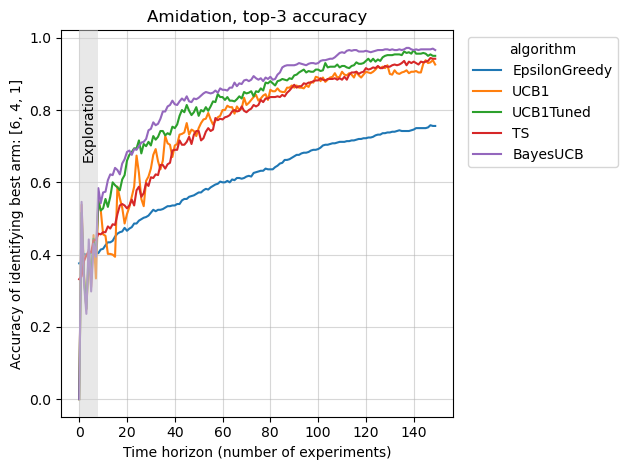

In [43]:
from chem_analyze import plot_accuracy_best_arm
import pickle

fn_list = [f'{d}log.csv' for d in dirs]
legend_list = ['EpsilonGreedy','UCB1', 'UCB1Tuned', 'TS', 'BayesUCB']

# since algorithms use indexes to differentiate arms, and we use ligand names,
# we need to do a search here with a saved arms_dict during optimization
with open(f'{dirs[0]}/arms.pkl', 'rb') as f:
    arms_dict = pickle.load(f)
reverse_arms_dict = {v: k for k, v in arms_dict.items()}

# now we can find indexes for the top-3 activators that we want.
top3 = ['DPPCl', 'BOP-Cl', 'TCFH']
activators = [(l,) for l in top3]  # arms_dict takes tuples
indexes = [reverse_arms_dict[l] for l in activators]

plot_accuracy_best_arm(best_arm_indexes=indexes,
                       fn_list=fn_list,
                       legend_list=legend_list,
                       shade_first_rounds=8,
                       title=f'Amidation, top-3 accuracy',
                       legend_title='algorithm',
                       long_legend=True)

In [ ]:
#####################
#test for different BayesUCB algorithms and Thompson Sampling algorithms

In [66]:
%%time
%%capture
import pandas as pd
from algos_regret import BayesUCBBeta, BayesUCBGaussian, BayesUCBBetaPPF, ThompsonSamplingBeta, ThompsonSamplingGaussianFixedVarSquared
from chem_arms import simulate_propose_and_update
import utils
from utils import make_dir

ground_truth = pd.read_csv('../dataset/noisy_amidation.csv')
ground_truth['yield'] = ground_truth['yield'].apply(utils.scaler)
ground_truth = ground_truth[['activator_name', 'solvent_name', 'base_name', 'nucleophile_id', 'yield']]

bases = ground_truth['base_name'].unique()
activators = ground_truth['activator_name'].unique()
solvents = ground_truth['solvent_name'].unique()
nucleophiles = ground_truth['nucleophile_id'].unique()

# dictionaries, algos and other things for optimization
scope_dict = {'base_name': bases,
              'activator_name': activators,
              'solvent_name': solvents,
              'nucleophile_id': nucleophiles} 
arms_dict = {'activator_name': activators}
n_arms = len(activators)
algos = [BayesUCBBeta(n_arms),
         BayesUCBGaussian(n_arms),
         BayesUCBBetaPPF(n_arms),
         ThompsonSamplingBeta(n_arms),
         ThompsonSamplingGaussianFixedVarSquared(n_arms),
        ]

wkdir = '../noisy_dataset_logs/amidation/'
num_sims = 200
num_round = 150
num_exp = 1

dirs = []  # for the plotting later

for algo in algos:
    dir_name = f'{wkdir}{algo.__str__()}-{num_sims}s-{num_round}r-{num_exp}e/'
    dirs.append(dir_name)
    make_dir(dir_name)

    simulate_propose_and_update(scope_dict, arms_dict, ground_truth, algo,
                                dir=dir_name,
                                num_sims=num_sims,
                                num_round=num_round,
                                num_exp=num_exp,
                                predict=False)

CPU times: user 3min 14s, sys: 4.59 s, total: 3min 19s
Wall time: 3min 17s


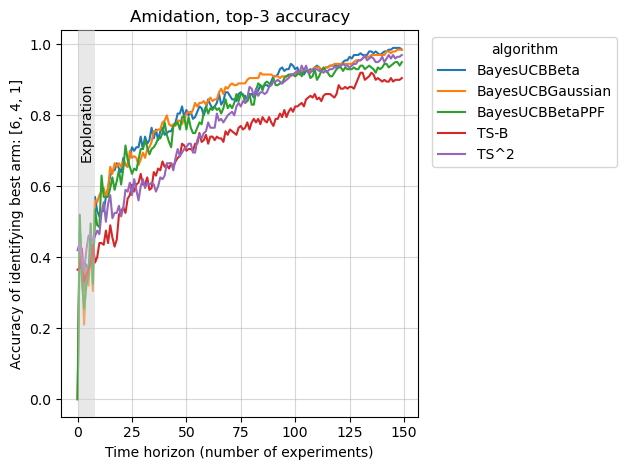

In [68]:
#test for different BayesUCB algorithms and TS algorithms
#Results shows BayesUCBGaussian gives the best performance in BayesUCB
# and ThompsonSamplingGaussianFixedVarSquared gives the best performance in TS algorithms
from chem_analyze import plot_accuracy_best_arm
import pickle

fn_list = [f'{d}log.csv' for d in dirs]
legend_list = ['BayesUCBBeta','BayesUCBGaussian', 'BayesUCBBetaPPF', 'TS-B', 'TS^2']

# since algorithms use indexes to differentiate arms, and we use ligand names,
# we need to do a search here with a saved arms_dict during optimization
with open(f'{dirs[0]}/arms.pkl', 'rb') as f:
    arms_dict = pickle.load(f)
reverse_arms_dict = {v: k for k, v in arms_dict.items()}

# now we can find indexes for the top-3 activators that we want.
top3 = ['DPPCl', 'BOP-Cl', 'TCFH']
activators = [(l,) for l in top3]  # arms_dict takes tuples
indexes = [reverse_arms_dict[l] for l in activators]

plot_accuracy_best_arm(best_arm_indexes=indexes,
                       fn_list=fn_list,
                       legend_list=legend_list,
                       shade_first_rounds=8,
                       title=f'Amidation, top-3 accuracy',
                       legend_title='algorithm',
                       long_legend=True)

In [ ]:
#####################
#test for different assumed sd and c values for BayesUCBGaussian and BayesUCBGaussianSquared

In [58]:
%%time
%%capture
import pandas as pd
from algos_regret import BayesUCBGaussian, BayesUCBGaussianSquared
from chem_arms import simulate_propose_and_update
import utils
from utils import make_dir

ground_truth = pd.read_csv('../dataset/noisy_amidation.csv')
ground_truth['yield'] = ground_truth['yield'].apply(utils.scaler)
ground_truth = ground_truth[['activator_name', 'solvent_name', 'base_name', 'nucleophile_id', 'yield']]

bases = ground_truth['base_name'].unique()
activators = ground_truth['activator_name'].unique()
solvents = ground_truth['solvent_name'].unique()
nucleophiles = ground_truth['nucleophile_id'].unique()

# dictionaries, algos and other things for optimization
scope_dict = {'base_name': bases,
              'activator_name': activators,
              'solvent_name': solvents,
              'nucleophile_id': nucleophiles} 
arms_dict = {'activator_name': activators}
n_arms = len(activators)
algos = [BayesUCBGaussian(n_arms, assumed_sd=0.25, c=1),
         BayesUCBGaussian(n_arms, assumed_sd=0.25, c=2),
         BayesUCBGaussian(n_arms, assumed_sd=0.5, c=2),
         BayesUCBGaussian(n_arms, assumed_sd=0.75, c=2),
         BayesUCBGaussian(n_arms, assumed_sd=1, c=2),
         BayesUCBGaussianSquared(n_arms, c=1),
         BayesUCBGaussianSquared(n_arms, c=2),
        ]

wkdir = '../noisy_dataset_logs/amidation/'
num_sims = 200
num_round = 96
num_exp = 1

dirs = []  # for the plotting later

for algo in algos:
    dir_name = f'{wkdir}{algo.__str__()}-{num_sims}s-{num_round}r-{num_exp}e/'
    dirs.append(dir_name)
    make_dir(dir_name)

    simulate_propose_and_update(scope_dict, arms_dict, ground_truth, algo,
                                dir=dir_name,
                                num_sims=num_sims,
                                num_round=num_round,
                                num_exp=num_exp,
                                predict=False)

CPU times: user 2min 34s, sys: 4.86 s, total: 2min 39s
Wall time: 2min 37s


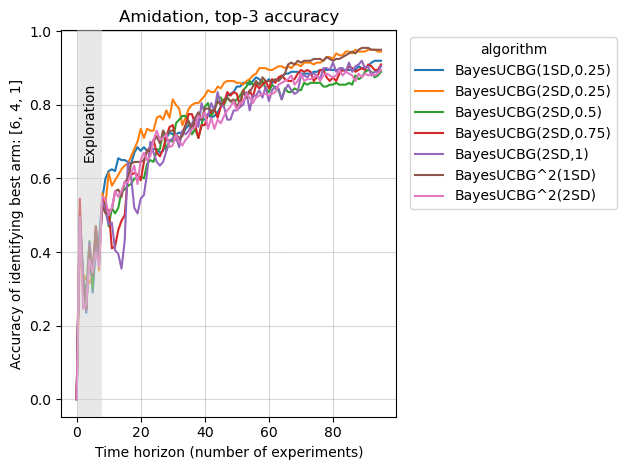

In [60]:
#test for different assumed sd and c values for BayesUCBGaussian and BayesUCBGaussianSquared
from chem_analyze import plot_accuracy_best_arm
import pickle

fn_list = [f'{d}log.csv' for d in dirs]
legend_list = ['BayesUCBG(1SD,0.25)','BayesUCBG(2SD,0.25)', 'BayesUCBG(2SD,0.5)', 'BayesUCBG(2SD,0.75)', 'BayesUCBG(2SD,1)', 'BayesUCBG^2(1SD)', 'BayesUCBG^2(2SD)']

# since algorithms use indexes to differentiate arms, and we use ligand names,
# we need to do a search here with a saved arms_dict during optimization
with open(f'{dirs[0]}/arms.pkl', 'rb') as f:
    arms_dict = pickle.load(f)
reverse_arms_dict = {v: k for k, v in arms_dict.items()}

# now we can find indexes for the top-3 activators that we want.
top3 = ['DPPCl', 'BOP-Cl', 'TCFH']
activators = [(l,) for l in top3]  # arms_dict takes tuples
indexes = [reverse_arms_dict[l] for l in activators]

plot_accuracy_best_arm(best_arm_indexes=indexes,
                       fn_list=fn_list,
                       legend_list=legend_list,
                       shade_first_rounds=8,
                       title=f'Amidation, top-3 accuracy',
                       legend_title='algorithm',
                       long_legend=True)

In [ ]:
# more testing for noisy dataset

In [ ]:
# 50% noise

In [86]:
import pandas as pd
import numpy as np

# load the original dataset
dataset = pd.read_csv('../dataset/amidation.csv')

# calculate the mean and standard deviation for noise generation
mu = 0
sigma = 0.5 * dataset['yield'].mean()

# create Gaussian noise with the same dimension as the 'yield' column
noise = np.random.normal(mu, sigma, dataset['yield'].shape)

# add the noise to the 'yield' column
dataset['yield'] = dataset['yield'] + noise

# save the modified dataset to a new CSV file
dataset.to_csv('../dataset/noisy_amidation2.csv', index=False)

In [88]:
%%time
%%capture
import pandas as pd
from algos_regret import EpsilonGreedy, UCB1, UCB1Tuned,ThompsonSamplingGaussianFixedVarSquared, BayesUCBGaussian
from chem_arms import simulate_propose_and_update
import utils
from utils import make_dir

ground_truth = pd.read_csv('../dataset/noisy_amidation2.csv')
ground_truth['yield'] = ground_truth['yield'].apply(utils.scaler)
ground_truth = ground_truth[['activator_name', 'solvent_name', 'base_name', 'nucleophile_id', 'yield']]

bases = ground_truth['base_name'].unique()
activators = ground_truth['activator_name'].unique()
solvents = ground_truth['solvent_name'].unique()
nucleophiles = ground_truth['nucleophile_id'].unique()

# dictionaries, algos and other things for optimization
scope_dict = {'base_name': bases,
              'activator_name': activators,
              'solvent_name': solvents,
              'nucleophile_id': nucleophiles} 
arms_dict = {'activator_name': activators}
n_arms = len(activators)
algos = [EpsilonGreedy(n_arms, 0.1),
         UCB1(n_arms),
         UCB1Tuned(n_arms),
         ThompsonSamplingGaussianFixedVarSquared(n_arms),
         BayesUCBGaussian(n_arms, assumed_sd=0.25, c=2),]

wkdir = '../noisy_dataset_logs/amidation2/'
num_sims = 500
num_round = 150
num_exp = 1

dirs = []  # for the plotting later

for algo in algos:
    dir_name = f'{wkdir}{algo.__str__()}-{num_sims}s-{num_round}r-{num_exp}e/'
    dirs.append(dir_name)
    make_dir(dir_name)

    simulate_propose_and_update(scope_dict, arms_dict, ground_truth, algo,
                                dir=dir_name,
                                num_sims=num_sims,
                                num_round=num_round,
                                num_exp=num_exp,
                                predict=False)

CPU times: user 8min 47s, sys: 15.2 s, total: 9min 3s
Wall time: 9min 2s


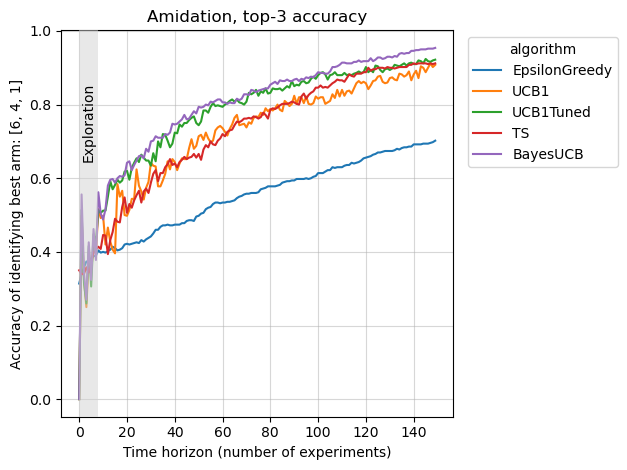

In [91]:
from chem_analyze import plot_accuracy_best_arm
import pickle

fn_list = [f'{d}log.csv' for d in dirs]
legend_list = ['EpsilonGreedy','UCB1', 'UCB1Tuned', 'TS', 'BayesUCB']

# since algorithms use indexes to differentiate arms, and we use ligand names,
# we need to do a search here with a saved arms_dict during optimization
with open(f'{dirs[0]}/arms.pkl', 'rb') as f:
    arms_dict = pickle.load(f)
reverse_arms_dict = {v: k for k, v in arms_dict.items()}

# now we can find indexes for the top-3 activators that we want.
top3 = ['DPPCl', 'BOP-Cl', 'TCFH']
activators = [(l,) for l in top3]  # arms_dict takes tuples
indexes = [reverse_arms_dict[l] for l in activators]

plot_accuracy_best_arm(best_arm_indexes=indexes,
                       fn_list=fn_list,
                       legend_list=legend_list,
                       shade_first_rounds=8,
                       title=f'Amidation, top-3 accuracy',
                       legend_title='algorithm',
                       long_legend=True)

In [ ]:
# test for differnet parameters of BayesUCB

In [93]:
%%time
%%capture
import pandas as pd
from algos_regret import BayesUCBGaussian, BayesUCBGaussianSquared
from chem_arms import simulate_propose_and_update
import utils
from utils import make_dir

ground_truth = pd.read_csv('../dataset/noisy_amidation2.csv')
ground_truth['yield'] = ground_truth['yield'].apply(utils.scaler)
ground_truth = ground_truth[['activator_name', 'solvent_name', 'base_name', 'nucleophile_id', 'yield']]

bases = ground_truth['base_name'].unique()
activators = ground_truth['activator_name'].unique()
solvents = ground_truth['solvent_name'].unique()
nucleophiles = ground_truth['nucleophile_id'].unique()

# dictionaries, algos and other things for optimization
scope_dict = {'base_name': bases,
              'activator_name': activators,
              'solvent_name': solvents,
              'nucleophile_id': nucleophiles} 
arms_dict = {'activator_name': activators}
n_arms = len(activators)
algos = [BayesUCBGaussian(n_arms, assumed_sd=0.25, c=1),
         BayesUCBGaussian(n_arms, assumed_sd=0.25, c=2),
         BayesUCBGaussian(n_arms, assumed_sd=0.5, c=2),
         BayesUCBGaussian(n_arms, assumed_sd=0.75, c=2),
         BayesUCBGaussian(n_arms, assumed_sd=1, c=2),
         BayesUCBGaussianSquared(n_arms, c=1),
         BayesUCBGaussianSquared(n_arms, c=2),
        ]

wkdir = '../noisy_dataset_logs/amidation/'
num_sims = 200
num_round = 96
num_exp = 1

dirs = []  # for the plotting later

for algo in algos:
    dir_name = f'{wkdir}{algo.__str__()}-{num_sims}s-{num_round}r-{num_exp}e/'
    dirs.append(dir_name)
    make_dir(dir_name)

    simulate_propose_and_update(scope_dict, arms_dict, ground_truth, algo,
                                dir=dir_name,
                                num_sims=num_sims,
                                num_round=num_round,
                                num_exp=num_exp,
                                predict=False)

CPU times: user 2min 39s, sys: 6.2 s, total: 2min 45s
Wall time: 2min 43s


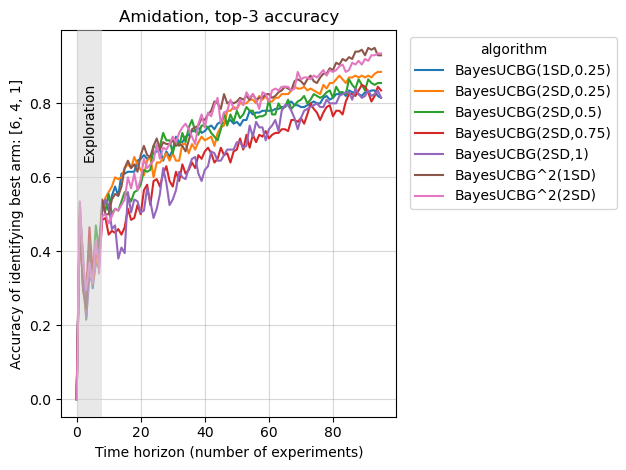

In [99]:
#test for different assumed sd and c values for BayesUCBGaussian and BayesUCBGaussianSquared
from chem_analyze import plot_accuracy_best_arm
import pickle

fn_list = [f'{d}log.csv' for d in dirs]
legend_list = ['BayesUCBG(1SD,0.25)','BayesUCBG(2SD,0.25)', 'BayesUCBG(2SD,0.5)', 'BayesUCBG(2SD,0.75)', 'BayesUCBG(2SD,1)', 'BayesUCBG^2(1SD)', 'BayesUCBG^2(2SD)']

# since algorithms use indexes to differentiate arms, and we use ligand names,
# we need to do a search here with a saved arms_dict during optimization
with open(f'{dirs[0]}/arms.pkl', 'rb') as f:
    arms_dict = pickle.load(f)
reverse_arms_dict = {v: k for k, v in arms_dict.items()}

# now we can find indexes for the top-3 activators that we want.
top3 = ['DPPCl', 'BOP-Cl', 'TCFH']
activators = [(l,) for l in top3]  # arms_dict takes tuples
indexes = [reverse_arms_dict[l] for l in activators]

plot_accuracy_best_arm(best_arm_indexes=indexes,
                       fn_list=fn_list,
                       legend_list=legend_list,
                       shade_first_rounds=8,
                       title=f'Amidation, top-3 accuracy',
                       legend_title='algorithm',
                       long_legend=True)